In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

# for emacs jupyter
%matplotlib inline
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

from analysis import plot_feature_distribution

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/sample_submission.csv")


<Figure size 432x288 with 0 Axes>

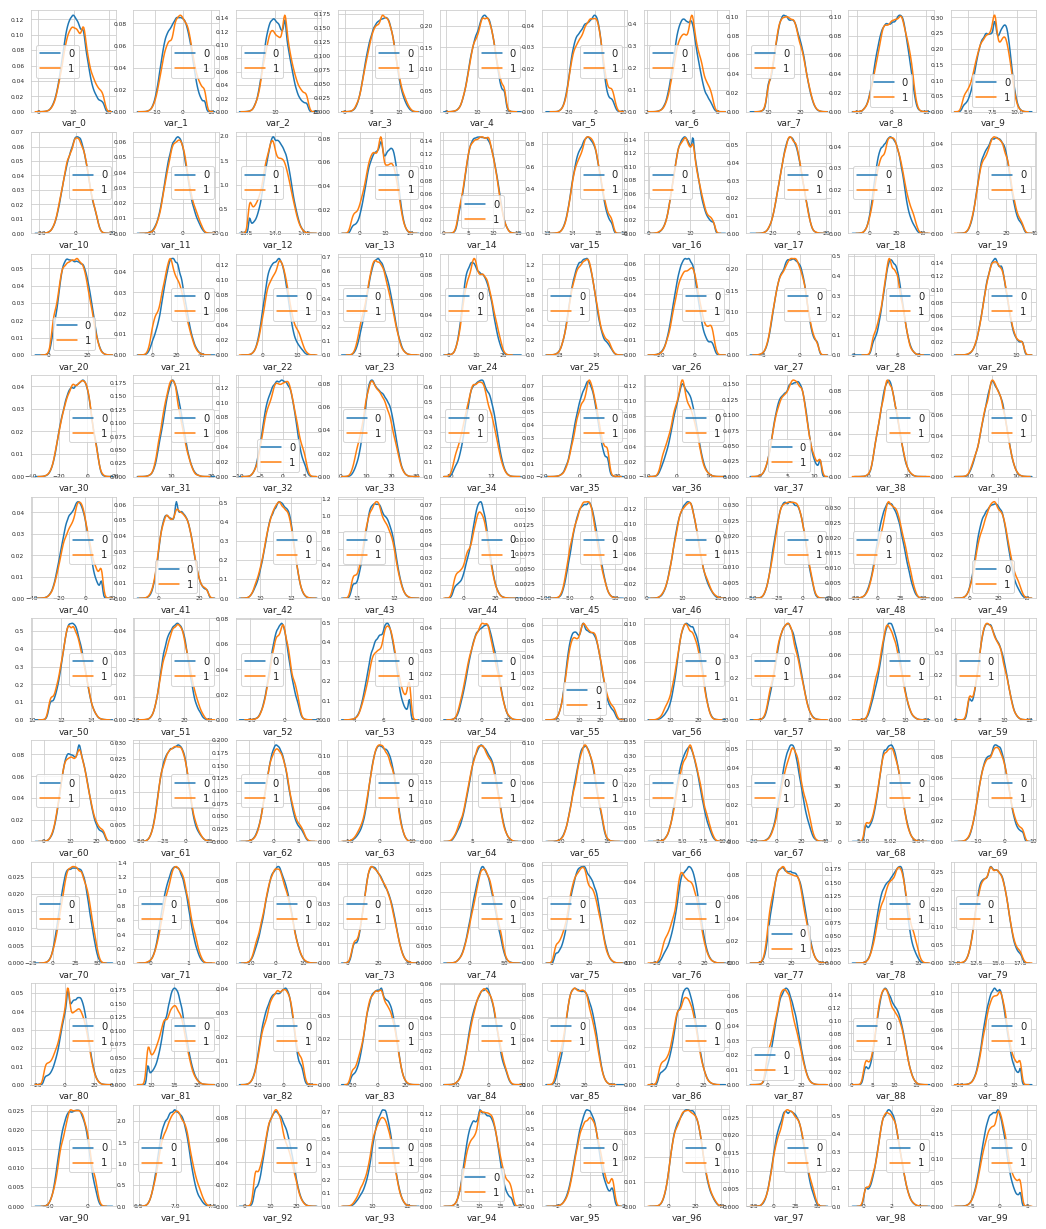

In [3]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

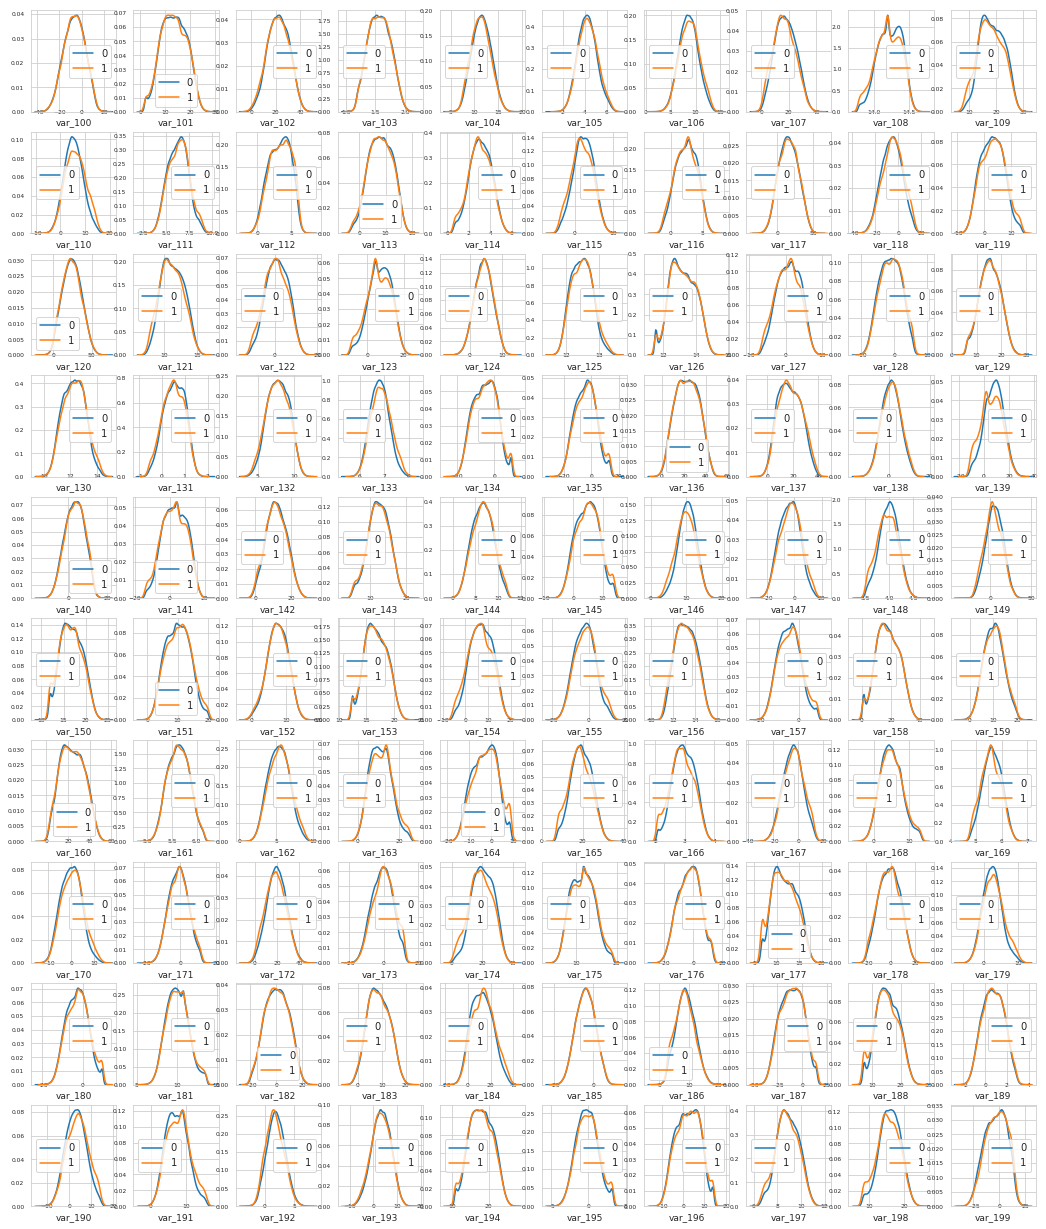

In [5]:
features = train.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

In [6]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']

In [7]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [9]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=42)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0


Training until validation scores don't improve for 3000 rounds.


[1000]	training's auc: 0.89904	valid_1's auc: 0.880364


[2000]	training's auc: 0.911204	valid_1's auc: 0.888868


[3000]	training's auc: 0.91903	valid_1's auc: 0.893151


[4000]	training's auc: 0.924854	valid_1's auc: 0.896012


[5000]	training's auc: 0.929701	valid_1's auc: 0.897714


[6000]	training's auc: 0.933934	valid_1's auc: 0.898494


[7000]	training's auc: 0.93786	valid_1's auc: 0.898994


[8000]	training's auc: 0.941613	valid_1's auc: 0.89928


[9000]	training's auc: 0.945152	valid_1's auc: 0.899671


[10000]	training's auc: 0.948466	valid_1's auc: 0.899878


[11000]	training's auc: 0.951758	valid_1's auc: 0.900177


[12000]	training's auc: 0.954863	valid_1's auc: 0.899992


[13000]	training's auc: 0.957793	valid_1's auc: 0.899881


[14000]	training's auc: 0.96065	valid_1's auc: 0.899628


Early stopping, best iteration is:
[11045]	training's auc: 0.951908	valid_1's auc: 0.900223


Fold 1


Training until validation scores don't improve for 3000 rounds.


[1000]	training's auc: 0.898872	valid_1's auc: 0.881324


[2000]	training's auc: 0.911092	valid_1's auc: 0.890141


[3000]	training's auc: 0.918887	valid_1's auc: 0.894037


[4000]	training's auc: 0.924725	valid_1's auc: 0.896563


[5000]	training's auc: 0.929615	valid_1's auc: 0.898167


[6000]	training's auc: 0.933852	valid_1's auc: 0.898875


[7000]	training's auc: 0.937735	valid_1's auc: 0.89924


[8000]	training's auc: 0.941427	valid_1's auc: 0.899545


[9000]	training's auc: 0.945019	valid_1's auc: 0.899597


[10000]	training's auc: 0.948402	valid_1's auc: 0.899566


[11000]	training's auc: 0.951631	valid_1's auc: 0.899664


[12000]	training's auc: 0.954666	valid_1's auc: 0.899486


[13000]	training's auc: 0.957626	valid_1's auc: 0.89939


Early stopping, best iteration is:
[10577]	training's auc: 0.950291	valid_1's auc: 0.899729


Fold 2


Training until validation scores don't improve for 3000 rounds.


[1000]	training's auc: 0.899456	valid_1's auc: 0.875464


[2000]	training's auc: 0.911636	valid_1's auc: 0.88445


[3000]	training's auc: 0.919401	valid_1's auc: 0.889283


[4000]	training's auc: 0.925163	valid_1's auc: 0.891698


[5000]	training's auc: 0.930008	valid_1's auc: 0.893217


[6000]	training's auc: 0.934161	valid_1's auc: 0.894368


[7000]	training's auc: 0.938011	valid_1's auc: 0.894915


[8000]	training's auc: 0.941698	valid_1's auc: 0.895107


[9000]	training's auc: 0.945271	valid_1's auc: 0.89496


[10000]	training's auc: 0.948626	valid_1's auc: 0.894985


Early stopping, best iteration is:
[7863]	training's auc: 0.941219	valid_1's auc: 0.895159


Fold 3


Training until validation scores don't improve for 3000 rounds.


[1000]	training's auc: 0.898755	valid_1's auc: 0.880937


[2000]	training's auc: 0.910972	valid_1's auc: 0.890718


[3000]	training's auc: 0.918966	valid_1's auc: 0.894582


[4000]	training's auc: 0.924802	valid_1's auc: 0.896677


[5000]	training's auc: 0.929742	valid_1's auc: 0.897598


[6000]	training's auc: 0.933987	valid_1's auc: 0.898084


[7000]	training's auc: 0.937911	valid_1's auc: 0.898305


[8000]	training's auc: 0.941628	valid_1's auc: 0.898558


[9000]	training's auc: 0.945165	valid_1's auc: 0.898465


[10000]	training's auc: 0.948493	valid_1's auc: 0.898567


[11000]	training's auc: 0.951717	valid_1's auc: 0.898491


[12000]	training's auc: 0.954791	valid_1's auc: 0.898268


Early stopping, best iteration is:
[9716]	training's auc: 0.947579	valid_1's auc: 0.898615


Fold 4


Training until validation scores don't improve for 3000 rounds.


[1000]	training's auc: 0.898756	valid_1's auc: 0.880866


[2000]	training's auc: 0.910845	valid_1's auc: 0.890799


[3000]	training's auc: 0.918796	valid_1's auc: 0.895208


[4000]	training's auc: 0.924658	valid_1's auc: 0.897531


[5000]	training's auc: 0.929576	valid_1's auc: 0.898924


[6000]	training's auc: 0.933837	valid_1's auc: 0.899703


[7000]	training's auc: 0.937772	valid_1's auc: 0.900308


[8000]	training's auc: 0.941416	valid_1's auc: 0.900431


[9000]	training's auc: 0.944971	valid_1's auc: 0.900233


[10000]	training's auc: 0.948268	valid_1's auc: 0.900028


[11000]	training's auc: 0.951548	valid_1's auc: 0.900111


Early stopping, best iteration is:
[8031]	training's auc: 0.941528	valid_1's auc: 0.900462


Fold 5


Training until validation scores don't improve for 3000 rounds.


[1000]	training's auc: 0.898106	valid_1's auc: 0.886226


[2000]	training's auc: 0.910525	valid_1's auc: 0.894652


[3000]	training's auc: 0.918514	valid_1's auc: 0.898661


[4000]	training's auc: 0.924481	valid_1's auc: 0.900751


[5000]	training's auc: 0.929454	valid_1's auc: 0.902105


[6000]	training's auc: 0.933804	valid_1's auc: 0.902821


[7000]	training's auc: 0.937765	valid_1's auc: 0.902995


[8000]	training's auc: 0.941446	valid_1's auc: 0.903154


[9000]	training's auc: 0.944993	valid_1's auc: 0.903363


[10000]	training's auc: 0.948314	valid_1's auc: 0.9034


[11000]	training's auc: 0.951562	valid_1's auc: 0.903391


[12000]	training's auc: 0.954655	valid_1's auc: 0.903289


[13000]	training's auc: 0.957648	valid_1's auc: 0.903262


Early stopping, best iteration is:
[10229]	training's auc: 0.949078	valid_1's auc: 0.903449


Fold 6


Training until validation scores don't improve for 3000 rounds.


[1000]	training's auc: 0.898631	valid_1's auc: 0.883448


[2000]	training's auc: 0.91088	valid_1's auc: 0.892046


[3000]	training's auc: 0.918802	valid_1's auc: 0.896592


[4000]	training's auc: 0.924723	valid_1's auc: 0.898649


[5000]	training's auc: 0.929617	valid_1's auc: 0.899721


[6000]	training's auc: 0.933906	valid_1's auc: 0.900308


[7000]	training's auc: 0.937832	valid_1's auc: 0.900717


[8000]	training's auc: 0.941555	valid_1's auc: 0.900916


[9000]	training's auc: 0.94506	valid_1's auc: 0.900607


[10000]	training's auc: 0.948425	valid_1's auc: 0.900518


Early stopping, best iteration is:
[7475]	training's auc: 0.939642	valid_1's auc: 0.900965


Fold 7


Training until validation scores don't improve for 3000 rounds.


[1000]	training's auc: 0.898676	valid_1's auc: 0.880199


[2000]	training's auc: 0.911049	valid_1's auc: 0.889752


[3000]	training's auc: 0.918968	valid_1's auc: 0.894568


[4000]	training's auc: 0.924842	valid_1's auc: 0.897449


[5000]	training's auc: 0.929663	valid_1's auc: 0.89896


[6000]	training's auc: 0.933875	valid_1's auc: 0.899934


[7000]	training's auc: 0.937866	valid_1's auc: 0.90027


[8000]	training's auc: 0.941586	valid_1's auc: 0.900556


[9000]	training's auc: 0.945083	valid_1's auc: 0.900757


[10000]	training's auc: 0.948416	valid_1's auc: 0.900799


[11000]	training's auc: 0.951675	valid_1's auc: 0.900676


[12000]	training's auc: 0.954768	valid_1's auc: 0.900403


[13000]	training's auc: 0.95775	valid_1's auc: 0.900246


Early stopping, best iteration is:
[10038]	training's auc: 0.948551	valid_1's auc: 0.900819


Fold 8


Training until validation scores don't improve for 3000 rounds.


[1000]	training's auc: 0.89779	valid_1's auc: 0.888166


[2000]	training's auc: 0.910458	valid_1's auc: 0.896618


[3000]	training's auc: 0.918615	valid_1's auc: 0.900943


[4000]	training's auc: 0.924387	valid_1's auc: 0.903001


[5000]	training's auc: 0.9293	valid_1's auc: 0.904178


[6000]	training's auc: 0.933534	valid_1's auc: 0.904738


[7000]	training's auc: 0.937463	valid_1's auc: 0.905103


[8000]	training's auc: 0.94117	valid_1's auc: 0.905392


[9000]	training's auc: 0.944675	valid_1's auc: 0.905481


[10000]	training's auc: 0.948106	valid_1's auc: 0.905589


[11000]	training's auc: 0.951319	valid_1's auc: 0.90545


[12000]	training's auc: 0.954441	valid_1's auc: 0.905497


[13000]	training's auc: 0.957453	valid_1's auc: 0.905272


Early stopping, best iteration is:
[10232]	training's auc: 0.948883	valid_1's auc: 0.905628


Fold 9


Training until validation scores don't improve for 3000 rounds.


[1000]	training's auc: 0.898783	valid_1's auc: 0.883983


[2000]	training's auc: 0.911112	valid_1's auc: 0.891819


[3000]	training's auc: 0.919056	valid_1's auc: 0.896176


[4000]	training's auc: 0.924853	valid_1's auc: 0.89825


[5000]	training's auc: 0.929797	valid_1's auc: 0.899577


[6000]	training's auc: 0.934085	valid_1's auc: 0.900182


[7000]	training's auc: 0.937978	valid_1's auc: 0.900687


[8000]	training's auc: 0.941648	valid_1's auc: 0.900745


[9000]	training's auc: 0.945235	valid_1's auc: 0.900773


[10000]	training's auc: 0.94862	valid_1's auc: 0.900838


[11000]	training's auc: 0.951843	valid_1's auc: 0.900587


[12000]	training's auc: 0.954894	valid_1's auc: 0.900639


Early stopping, best iteration is:
[9691]	training's auc: 0.947612	valid_1's auc: 0.900898


CV score: 0.90053 


In [10]:
submission["target"] = predictions
submission.to_csv("./submission_files/submission_LGB.csv", index=False)
